In [1]:
import bs4
import torch.nn as nn
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,re,json
import torch.nn as nn
import shutil
from torch.utils.data import TensorDataset,DataLoader
import gc,time
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score,accuracy_score
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('/content/drive/My Drive/vectors/processed_df.csv')
#dropping null values
df = df.dropna(axis=0)
df.head()

,Time,clean_text,Score
0,1303862400,bought several vitality canned dog food produc...,1
1,1346976000,product arrived labeled jumbo salted peanuts p...,0
2,1219017600,confection around centuries light pillowy citr...,1
3,1307923200,looking secret ingredient robitussin believe f...,0
4,1350777600,great taffy great price wide assortment yummy ...,1


In [3]:
df['Time'] = pd.to_datetime(df['Time'],unit='s')
df = df.sort_values('Time')
df = df.reset_index(drop=True)
df.shape

(392915, 3)

In [4]:
X = df['clean_text']
y = df['Score']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=100)

print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (275040,)
shape of X_test is (117875,)
shape of y_train is (275040,)
shape of y_test is (117875,)


In [5]:
#helper functions
def tockenize(X_train,X_test):
  """
  bow encoding
  """
  word_list = []
  for sent in X_train:
    for word in sent.split():
      word_list.append(word)

  corpus = Counter(word_list)
  # sorting on the basis of most common words
  corpus_ = sorted(corpus,key=corpus.get,reverse=True)
  # creating a dict
  onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

  train_vec = []
  test_vec = []
  for sent in X_train:
      train_vec.append([onehot_dict[word] for word in sent.split() if word in onehot_dict.keys()])

  for sent in X_test:
      test_vec.append([onehot_dict[word] for word in sent.split() if word in onehot_dict.keys()])

  return train_vec,test_vec,onehot_dict

def padding_(sentences, seq_len):
    """
    do padding on left handside
    ie, if seq_len = 5 and input is [1,2,3] out will be [0,0,1,2,3]

    """
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [6]:
X_train = X_train.values
X_test = X_test.values
train_seq,  test_seq,corpus_dict = tockenize(X_train,X_test)
corpus = [i for i in corpus_dict.keys()]
print(f'Total number of words {len(corpus)}')

Total number of words 101648


In [7]:
 import json
# convert into JSON:
with open("corpus_dict", "w") as fp:
    json.dump(corpus_dict,fp) 

In [8]:
print(X_train[162])
print(train_seq[162])

given young dog persistent loose stools older dog also problems loose stools adult formula immediately rectified change innova see large number serious complaints web new formulation buying
[528, 1521, 47, 9790, 733, 2566, 1183, 47, 20, 468, 733, 2566, 1424, 473, 707, 14866, 512, 3772, 121, 258, 785, 1718, 1696, 1543, 152, 5127, 124]


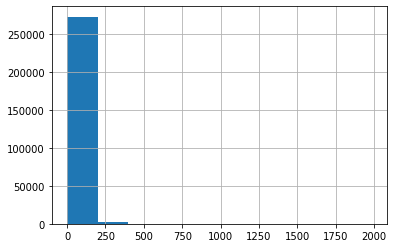

count    275040.000000
mean         39.898117
std          38.840086
min           1.000000
25%          17.000000
50%          28.000000
75%          49.000000
max        1983.000000
dtype: float64

In [9]:
rev_len = [len(i) for i in train_seq]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

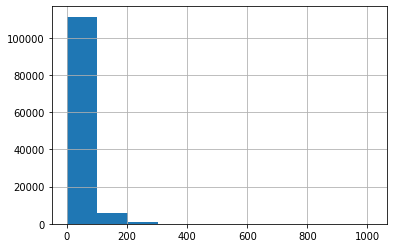

count    117875.000000
mean         39.640874
std          38.351756
min           1.000000
25%          17.000000
50%          28.000000
75%          48.000000
max        1013.000000
dtype: float64

In [10]:
rev_len = [len(i) for i in test_seq]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [11]:
seq_train_pad = padding_(np.array(train_seq),225)
seq_test_pad = padding_(np.array(test_seq),225)

In [12]:
seq_train_pad[163]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

Embebing

In [13]:

def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

glove_dict =  loadGloveModel("/content/drive/My Drive/vectors/glove.42B.300d.txt")
gc.collect()

Loading Glove Model
1917494  words loaded!


6327

In [14]:
embedding_matrix = np.zeros((len(corpus) + 1, 300))
for i,word in enumerate(corpus):
  if word in glove_dict.keys():
    embedding_vec = glove_dict[word]
    embedding_matrix[i] = embedding_vec

 
print(embedding_matrix.shape)  

np.save('/content/drive/My Drive/vectors/embedding_matrix_model.npy',embedding_matrix)

(101649, 300)


In [15]:
#loading embedding
embedding_matrix = np.load('/content/drive/My Drive/vectors/embedding_matrix_model.npy')


final_train = seq_train_pad
final_test = seq_test_pad
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(final_train), torch.from_numpy(y_train.values))
test_data = TensorDataset(torch.from_numpy(final_test), torch.from_numpy(y_test.values))

# dataloaders
batch_size = 500

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data,  batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data,  batch_size=batch_size, shuffle=True )

In [16]:
for x,y in train_loader:
  print(x.shape)
  print(y.shape) 
  break

torch.Size([500, 225])
torch.Size([500])


Modelo 1.

In [17]:
class Network(nn.Module):
  def __init__(self,embedding_matrix,hidden_dim,no_layers=1):
    super().__init__()
    vocab_size = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    self.hidden_dim = hidden_dim
    self.n_layers = no_layers
    self.embedding = nn.Embedding(vocab_size,embedding_dim)
    self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
    self.embedding.weight.requires_grad = False

    self.lstm = nn.LSTM(embedding_dim,hidden_size=self.hidden_dim,batch_first=True,num_layers=self.n_layers)
    self.dropout = nn.Dropout(0.2)
    self.linear1 = nn.Linear(self.hidden_dim,self.hidden_dim//2)
    self.linear2 = nn.Linear(self.hidden_dim//2,2)

  def forward(self,x):
    batch_size= x.shape[0]     #batch_size,seq_len
    x = self.embedding(x)      #batch_size,seq_len,embed_dim
    lstm_out,h = self.lstm(x)  #batch_size,seq_len,hidden_dim*no_layers 
    lstm_out = self.dropout(lstm_out)
    lstm_out = lstm_out.contiguous().view(-1,self.hidden_dim)  #batch_size*seq_len*no_layers,hidden_dim
    out = self.linear1(lstm_out)   #batch_size*seq_len*no_layers, out_dim
    out = self.linear2(out)
    out = out.view(batch_size,-1) #batch_size,seq_len*out_dim*no_layers
    return out[:,-2:]

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Network(embedding_matrix,hidden_dim=100,no_layers=1)
model = model.to(device)
model

Network(
  (embedding): Embedding(101649, 300)
  (lstm): LSTM(300, 100, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=100, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=2, bias=True)
)

In [19]:
criterion = nn.CrossEntropyLoss()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(params=parameters,lr=0.001)


# helper functions
#function to calculate auc and accuracy
def score(y,y_pred,y_prob_pred):
  roc_score = roc_auc_score(y,y_prob_pred)
  acc = accuracy_score(y,y_pred)
  return roc_score, acc

def save_ckp(state, is_best, checkpoint_path, best_model_path):
  """
  state: checkpoint we want to save
  is_best: is this the best checkpoint; min validation loss
  checkpoint_path: path to save checkpoint
  best_model_path: path to save best model
  """
  # save checkpoint data to the path given, checkpoint_path
  torch.save(state, checkpoint_path)
  # if it is a best model, min validation loss
  if is_best:
  # copy that checkpoint file to best path given, best_model_path
      shutil.copyfile(checkpoint_path, best_model_path)

In [ ]:
metrics = {'train_auc': [],'test_auc' : [], 'train_accuracy':[], 'test_accuracy':[], 'train_loss':[],'test_loss': []}
epochs = 7
checkpoint_path = '/content/drive/My Drive/vectors/models/chkpoint1_'
best_model_path = '/content/drive/My Drive/vectors/models/bestmodel1.pt'
test_loss_min = np.Inf

for epoch in range(epochs):
    start_time = time.time()
    print(f'Epoch {epoch + 1}')
    AUC = 0.0 
    ACC = 0.0
    LOSS = 0.0
    model.train()
    for x,y in train_loader:
        batch_size = x.shape[0]
        x = x.long()
        y = y.long()
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred,y)
        loss.backward()
        # nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()
        _, y_hat_pred = torch.max(y_pred,axis=1)
        y_hat_prob = y_pred[:,-1]
        y_, y_hat_pred_,y_hat_prob_ = y.detach(), y_hat_pred.detach(), y_hat_prob.detach()
        auc_score, acc = score(y_.cpu().numpy(), y_hat_pred_.cpu().numpy(), y_hat_prob_.cpu().numpy())
        ACC += (acc * batch_size)
        LOSS += (loss * batch_size)
        AUC += (auc_score * batch_size)

    epoch_auc = AUC / len(train_loader.dataset)
    train_epoch_loss = LOSS / len(train_loader.dataset)
    epoch_accuracy = ACC / len(train_loader.dataset)
    metrics['train_auc'].append(epoch_auc)
    metrics['train_accuracy'].append(epoch_accuracy)
    metrics['train_loss'].append(train_epoch_loss)
    print(f'Train:  Loss: {train_epoch_loss}, Accuracy: {epoch_accuracy}, AUC: {epoch_auc}')


    AUC = 0.0 
    ACC = 0.0
    LOSS = 0.0
    model.eval()
    with torch.no_grad():
      for x,y in test_loader:
        batch_size = x.shape[0]
        x = x.long()
        y = y.long()
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred,y)
        _, y_hat_pred = torch.max(y_pred,axis=1)
        y_hat_prob = y_pred[:,-1]
        y_, y_hat_pred_,y_hat_prob_ = y.detach(), y_hat_pred.detach(), y_hat_prob.detach()  # detaching from torch graph to use it for calculation auc
        auc_score, acc = score(y_.cpu().numpy(), y_hat_pred_.cpu().numpy(), y_hat_prob_.cpu().numpy())
        ACC += (acc * batch_size)
        LOSS += (loss * batch_size)
        AUC += (auc_score * batch_size)

    epoch_auc = AUC / len(test_loader.dataset)
    test_epoch_loss = LOSS / len(test_loader.dataset)
    epoch_accuracy = ACC / len(test_loader.dataset)

    metrics['test_auc'].append(epoch_auc)
    metrics['test_accuracy'].append(epoch_accuracy)
    metrics['test_loss'].append(test_epoch_loss)
    print(f'Validation Loss: {test_epoch_loss}, Accuracy: {epoch_accuracy}, AUC: {epoch_auc}')
    #save checkpoint
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': test_epoch_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    if test_epoch_loss <= train_epoch_loss and test_epoch_loss <= test_loss_min:
        print('Validation loss decreased ({:.6f}).  Saving model ...'.format(test_epoch_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        test_loss_min = test_epoch_loss

    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('--'*50)

Epoch 1
